# Análise Exploratória de Dados

O objetivo da análise consiste na execução de tarefas do Data Understanding e Preparation (Crisp-DM) para o deploy de um modelo de previsão de quantidade de produtos exportados para o ano atual baseado no histórico de dados e de um modelo de Clustering (Categorização) a partir das features presentes nos datasets gerados.
Partimos do pressuposto de que o usuário-final tem interesse em explorar os dados de vitivinicultura da Embrapa para criar estratégias de melhoria nas atividades da cadeia produtiva. Entre elas, a exportação, que consiste em uma etapa vital desse nicho produtivo e da política econômica nacional.

**Resumo dos Procedimentos realizados:**

* Set up do conjunto de bibliotecas da linguagem Python e carregamento dos dados.<br>

**Data Cleaning e Wrangling:**
* Renome de colunas do dataset **tbl_export** oriundos do banco de dados.<br>
Remoção de caracteres das colunas `pais` e `pais_corrigido` para junção dos datasets.<br>
Tratamento dos valores da coluna `pais` a partir de dados do dataset **tbl_depara_paises**.<br>
Junção do dataset **tbl_export** com os dados das tabelas **tbl_cd_pais** e **tbl_dados_paises** para análise dos dados.<br>
Remoção da colunas duplicadas resultante do processo de junção das tabelas.<br>
Filtragem 28.614 linhas vazias reduzindo a esparcidade dos dados.<br>
Alteração dos pontos decimais para vazio e transformação do tipo de dado das colunas `pais` e `valor_dolar` para o tipo int.<br>
Verificação das linhas duplicadas: cada registro precisa ser exclusivo e corresponde a uma operação realizada pela combinação país-tipo de produto.<br>
Tratamento de valores nulos com imputação simples.<br>
Agrupamento de dados para gerar o dataset usado no modelo de clustering.


**Feature Engineering:**
* Construção de uma categoria de países para redução de dimensionalidade dos dados. Países com 3x10-^6% da quantidade total dos países podem ser agrupados em uma classe outros.<br>
Construção da coluna `valor_dolar_ajustado` , que converte a coluna `valor_dolar` para valor monetário atual através da biblioteca CPI do WbData.<br>
Construção de colunas lag de valores para validar a influência dos dados de séries temporal.
Seleção de colunas para o dataset de clustering e regressão.

**Análises**
* Distribuição dos dados: Análise de necessidade de técnica de Scale e Encoding dos dados. <br>
Distribuição dos dados para avalição de normalidade com histograma e qq-plot.<br>
Teste de Normalidade dos dados com Shapiro-Wilk.<br>
Análise de Correlação das colunas para identificação de multicolinearidade.<br>
Teste VIF para análise de multicolinearidade.<br>






## Set up
Carregamento de bibliotecas, funções e objetos para execução dos processos de limpeza e exploração dos dados.

In [153]:
# carregamento de bibliotecas

# manipulação de dados
import sys
import pandas as pd
import numpy as np
sys.path.append('..')
import unidecode
import cpi

# funções banco de dados
from config.database import data_collection, api_collection
from config.schema import obter_item_import_export_db


# funções de eda e pre-processing
from src.eda_preprocessing import *

# visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# tratamento de dados
from sklearn.preprocessing import PowerTransformer

In [154]:
# remoção de warnings
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

## Carregamento dos dados

In [155]:
# carregamento da fonte de dados e e contrução da tabela

# cursor de dados do mongodb
dados_mongo_db = data_collection.find(
                {'processo': 'Exportação'})

# transformação em lista de dicionários
lista_dados = list(dados_mongo_db)

# lista que recebe os dados da tabela no laço de repetição
dados_tabela = []

# laço de repetição para transformar os dados no formato tabular
for doc in lista_dados:
    item = obter_item_import_export_db(doc)
    dados_tabela.extend(item.expand_data())

# carregamento da tabela de dados
tbl_export = pd.DataFrame(dados_tabela)
tbl_export.head()

,ano,processo,produto,produto_texto,Países,Quantidade (Kg),Valor (US$)
0,1970,Exportação,01,Vinhos de mesa,Afeganistão,-,-
1,1970,Exportação,01,Vinhos de mesa,África do Sul,-,-
2,1970,Exportação,01,Vinhos de mesa,"Alemanha, República Democrática",-,-
3,1970,Exportação,01,Vinhos de mesa,Angola,-,-
4,1970,Exportação,01,Vinhos de mesa,Anguilla,-,-


In [156]:
# carregamento da base de códigos no formato dataframe
tbl_cd_pais = pd.read_csv('../data/external/codigos_paises_wb.csv')

In [157]:
# carregamento da base de dados econonômicos dos países
tbl_dados_paises = pd.read_csv('../data/processed/indicadores_economicos_processed.csv')

In [158]:
# carregamento da base de_para para tratamento dos nomes de países
tbl_depara_paises = pd.read_csv('../data/external/de_para_paises.csv', sep=';')

## Data Cleaning e Wrangling

In [159]:
# tratamento do nome das colunas 
tbl_export = tbl_export.rename(columns={'Países':'pais', 'Quantidade (Kg)':'qtde_kg', 'Valor (US$)':'valor_dolar'})
tbl_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27918 entries, 0 to 27917
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ano            27918 non-null  int64 
 1   processo       27918 non-null  object
 2   produto        27918 non-null  object
 3   produto_texto  27918 non-null  object
 4   pais           27918 non-null  object
 5   qtde_kg        27918 non-null  object
 6   valor_dolar    27918 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB


In [160]:
# remoção dos acentos gráficos com a função unicode.
tbl_export['pais'] = tbl_export['pais'].apply(
        lambda x: unidecode.unidecode(x))

tbl_cd_pais['pais_corrigido'] = tbl_cd_pais['pais_corrigido'].apply(
        lambda x: unidecode.unidecode(x))

In [161]:
# correção dos nomes dos paises oriundos do banco de dados.
depara = tbl_depara_paises.set_index(tbl_depara_paises['Pais'])['pais_corrigido'].to_dict()

tbl_export['pais'] = tbl_export['pais'].replace(depara)

In [162]:
# junção das tabelas para análise dos dados.
tbl_export = tbl_export.merge(tbl_cd_pais,left_on=['pais'],  right_on=['pais_corrigido'], how='left')\
            .merge(tbl_dados_paises,left_on = ['codigo_WB', 'ano'], right_on=['codigo_WB', 'date'], how='left')
    

### Matriz com alta esparcidade dos dados.
Como os dados são oriundos de junção tabelas históricas que armazenam os registros de anos, identificamos a presença de muitas linhas sem presença de valores, apenas com a referência de países; por isso, precisamos remover essas linhas para diminuir a esparcidade dos dados, além de remover colunas que surgiram pelo processo de junção de tabelas.

In [163]:
# verificação das informações do dataset completo.
tbl_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34398 entries, 0 to 34397
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ano                         34398 non-null  int64  
 1   processo                    34398 non-null  object 
 2   produto                     34398 non-null  object 
 3   produto_texto               34398 non-null  object 
 4   pais                        34398 non-null  object 
 5   qtde_kg                     34398 non-null  object 
 6   valor_dolar                 34398 non-null  object 
 7   country_x                   29700 non-null  object 
 8   pais_corrigido_x            29700 non-null  object 
 9   codigo_WB                   29700 non-null  object 
 10  country_y                   29484 non-null  object 
 11  date                        29484 non-null  float64
 12  PIB_total_(dolar_corrente)  27811 non-null  float64
 13  população_total             294

In [164]:
# remoção de colunas duplicadas geradas pelo processo de junção das tabelas.
tbl_export.drop(columns=['produto','processo','country_x', 'country_y','pais_corrigido_x', 'pais_corrigido_y','date'], inplace=True)

In [165]:
# verificação de nulos
dados_nulos = contagem_nulos(tbl_export)
dados_nulos

ano                               0
produto_texto                     0
pais                              0
qtde_kg                           0
valor_dolar                       0
codigo_WB                      4698
PIB_total_(dolar_corrente)     6587
população_total                4914
PIB_per_capita                 6587
taxa_crescimento_PIB           6933
taxa_inflação_(CPI)           10038
expectativa_vida               4914
taxa_alfabetização             4914
exportacao_abs                10723
importacao_abs                10719
IDH_estimado                  19515
dtype: int64

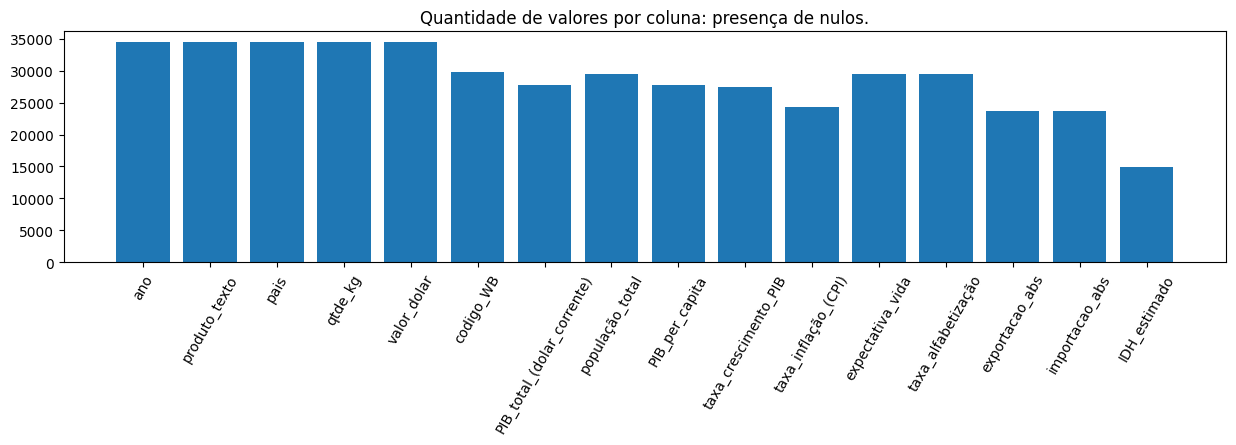

In [166]:
# visualização de valores nulos
gerar_grafico_valores_nulos(df = tbl_export, dados_nulos=dados_nulos)

In [167]:
# filtragem de valor 'Total' da coluna países
tbl_export.query("pais!='Total'", inplace=True)

In [168]:
# filtragem de 28.398 linhas vazias para redução da esparcidade dos dados
tbl_export = tbl_export[tbl_export['qtde_kg']!='-']

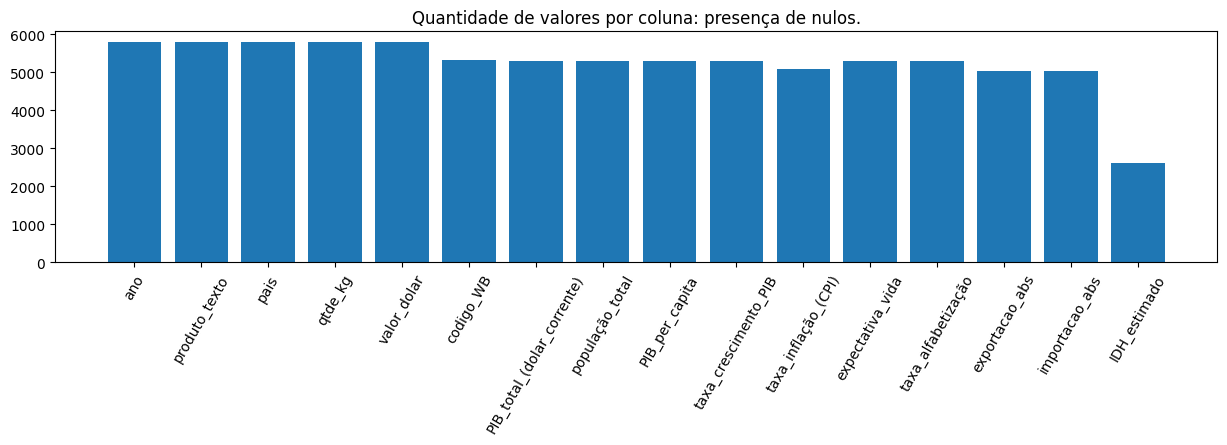

In [169]:
# visualização de valores nulos após processo de tratamento com filtragem de dados
dados_nulos = contagem_nulos(tbl_export)
gerar_grafico_valores_nulos(df = tbl_export, dados_nulos=dados_nulos)

In [170]:
# substituição de caracteres e transformação do tipo de dado.
tbl_export['qtde_kg'] = tbl_export['qtde_kg'].str.replace('.', '', regex=False).astype(int)
tbl_export['valor_dolar'] = tbl_export['valor_dolar'].str.replace('.', '', regex=False).astype(int)

In [171]:
# verificação de linhas duplicadas
tbl_export[tbl_export.duplicated()]

,ano,produto_texto,pais,qtde_kg,valor_dolar,codigo_WB,PIB_total_(dolar_corrente),população_total,PIB_per_capita,taxa_crescimento_PIB,taxa_inflação_(CPI),expectativa_vida,taxa_alfabetização,exportacao_abs,importacao_abs,IDH_estimado
57,1970,Vinhos de mesa,Colombia,14205,6650,COL,7.198360e+09,20811782.0,345.879102,6.207797,6.908623,61.465000,95.0,9.552596e+10,1.047701e+11,NaN
58,1970,Vinhos de mesa,Colombia,14205,6650,COL,7.198360e+09,20811782.0,345.879102,6.207797,6.908623,61.465000,95.0,9.552596e+10,1.047701e+11,NaN
59,1970,Vinhos de mesa,Colombia,14205,6650,COL,7.198360e+09,20811782.0,345.879102,6.207797,6.908623,61.465000,95.0,9.552596e+10,1.047701e+11,NaN
694,1971,Vinhos de mesa,Colombia,3780,2475,COL,7.820381e+09,21319096.0,366.825168,5.960728,11.940262,62.005000,95.0,9.358210e+10,1.252577e+11,NaN
695,1971,Vinhos de mesa,Colombia,3780,2475,COL,7.820381e+09,21319096.0,366.825168,5.960728,11.940262,62.005000,95.0,9.358210e+10,1.252577e+11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34287,2023,Suco de uva,Canada,29504,72670,CAN,2.142471e+12,40097761.0,53431.185706,1.248927,3.879002,81.646585,95.0,7.149276e+13,7.246520e+13,NaN
34288,2023,Suco de uva,Canada,29504,72670,CAN,2.142471e+12,40097761.0,53431.185706,1.248927,3.879002,81.646585,95.0,7.149276e+13,7.246520e+13,NaN
34373,2023,Suco de uva,Republica Dominicana,25440,78719,DOM,1.214443e+11,11331265.0,10717.627671,2.360616,4.785613,73.720000,95.5,2.567181e+12,3.458317e+12,0.821982
34374,2023,Suco de uva,Republica Dominicana,25440,78719,DOM,1.214443e+11,11331265.0,10717.627671,2.360616,4.785613,73.720000,95.5,2.567181e+12,3.458317e+12,0.821982


In [172]:
# contagem de linhas duplicadas no dataset
(
    tbl_export.groupby(tbl_export.columns.tolist(), dropna=False)
    .size()
    .to_frame('n_duplicates')
    .query('n_duplicates>1')
    .sort_values(by ='n_duplicates', ascending=False)
    .head(5)
)

n_duplicates
ano  produto_texto  pais     qtde_kg valor_dolar codigo_WB PIB_total_(dolar_corrente) população_total PIB_per_capita taxa_crescimento_PIB taxa_inflação_(CPI) expectativa_vida taxa_alfabetização exportacao_abs importacao_abs IDH_estimado              
2023 Vinhos de mesa Colombia 450     1259        COL       3.634938e+11               52321152.0      6947.359287    0.610410             11.735904           77.725000        96.0               6.483748e+12   8.235499e+12   0.786184                 4
1970 Vinhos de mesa Colombia 14205   6650        COL       7.198360e+09               20811782.0      345.879102     6.207797             6.908623            61.465000        95.0               9.552596e+10   1.047701e+11   NaN                      4
1971 Suco de uva    Canada   1250    625         CAN       9.960645e+10               21962032.0      4535.393389    4.018845             2.704918            73.029268        95.0               2.091305e+12   1.961378e+12   NaN                      4
     Vinhos de mesa Colombia 3780    2475        COL       7.820381e+09               21319096.0      366.825168     5.960728             11.940262           62.005000        95.0               9.358210e+10   1.252577e+11   NaN                      4
1972 Vinhos de mesa Colombia 1294    771         COL       8.671359e+09               21819563.0      397.412117     7.669148             12.444459           62.530000        95.0               1.149373e+11   1.109770e+11   NaN                      4

In [173]:
# remoção de valores duplicados
tbl_export.drop_duplicates(keep='first', inplace=True)

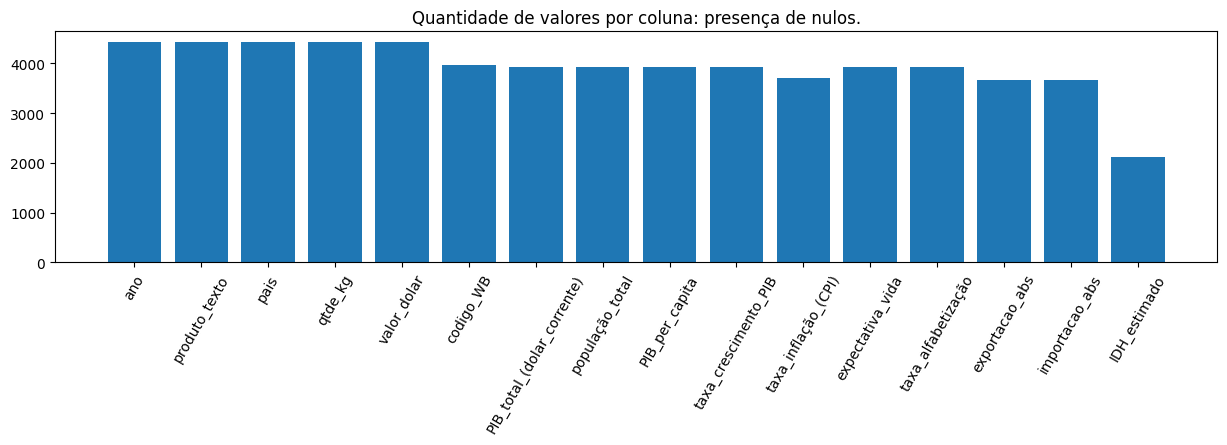

In [174]:
# verificação do dataset após tratamento de remoção de valores duplicados
dados_nulos = contagem_nulos(tbl_export)
gerar_grafico_valores_nulos(df = tbl_export, dados_nulos=dados_nulos)

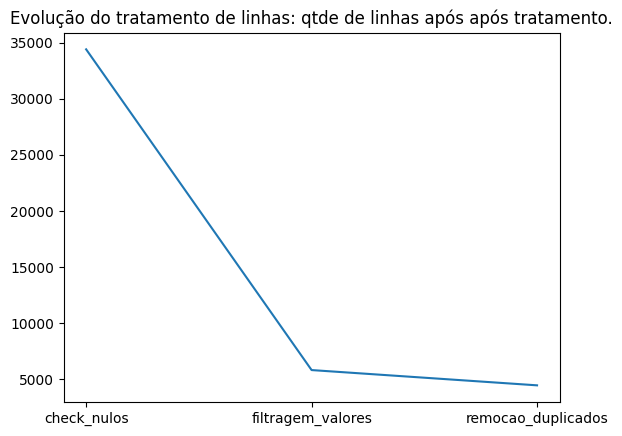

In [175]:
# evolução do dataset após os tratamentos
dict_processos = {'processos':['check_nulos', 'filtragem_valores', 'remocao_duplicados'] , 'qtde_linhas':[34398, 5784, 4422]}
plt.plot(dict_processos['processos'], dict_processos['qtde_linhas'])
plt.title('Evolução do tratamento de linhas: qtde de linhas após após tratamento.')
plt.show()

# Dataset tratado para o processo de feature engineering e execução de análise exploratória
Passamos de um dataset com mais de 39 mil linhas para 4 mil linhas realizando procedimentos de tratamento de valores nulos, filtragem de valores inconsistentes no dataset e remoção de valores duplicados.

In [176]:
# visualização do dataset
tbl_export.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4422 entries, 12 to 34396
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ano                         4422 non-null   int64  
 1   produto_texto               4422 non-null   object 
 2   pais                        4422 non-null   object 
 3   qtde_kg                     4422 non-null   int64  
 4   valor_dolar                 4422 non-null   int64  
 5   codigo_WB                   3969 non-null   object 
 6   PIB_total_(dolar_corrente)  3929 non-null   float64
 7   população_total             3932 non-null   float64
 8   PIB_per_capita              3929 non-null   float64
 9   taxa_crescimento_PIB        3927 non-null   float64
 10  taxa_inflação_(CPI)         3717 non-null   float64
 11  expectativa_vida            3932 non-null   float64
 12  taxa_alfabetização          3932 non-null   float64
 13  exportacao_abs              3673 non

## Feature Engineering

### Alto volume de valores categóricos na coluna países
Como a fonte de dados disponibiliza um relatório com a relação de todos os países, acabamos armazenando um alto volume de valores na feature `pais`. Portanto, para modelos de ML, precisamos realizar algum tipo de tratamento específico para reduzir a dimensionalidade, evitando uma explosão em eventuais processos de encoding, e reduzindo a esparcidade dos dados, e o efeito do long-tail apresentado abaixo.
Assim, criamos uma feature para reduzir a dimensionalidade dos países baseado na frequência de consumo histórico.
Categorias:<br>
* Primeiros 30 países consumidores: cat_A.<br>
Demais categorias com intervalo de 50 países: cat_B, cat_C, cat_D.<br>
Países com um volume abaixo de 35 kg serão agrupados em uma categoria 'outros'.


In [177]:
# contagem de valores da coluna pais: 189 países que apresentam dados entre 1970 a 2024.
print(f"Valores únicos: {len(tbl_export['pais'].unique())}")
tbl_export['pais'].value_counts()

Valores únicos: 179


pais
Estados Unidos                        166
Paraguai                              162
Canada                                140
Alemanha, Republica Democratica da    138
Japao                                 127
                                     ... 
Samoa Americana                         1
Malavi                                  1
Cook, Ilhas                             1
Macedonia                               1
Quirguistao                             1
Name: count, Length: 179, dtype: int64

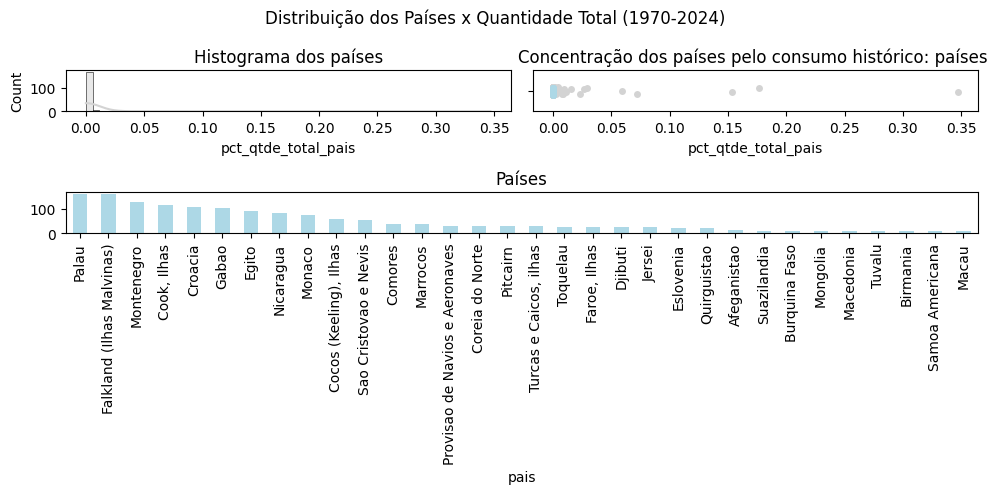

In [178]:
# visualização da calda longa de países em relação ao consumo.

# agrupamento dos dados
tbl_agrupada = tbl_export.groupby(['pais'])[['qtde_kg','valor_dolar']].sum().sort_values(by=['qtde_kg'], ascending=False)
tbl_agrupada['pct_qtde_total_pais'] = tbl_agrupada[['qtde_kg']].div(tbl_agrupada['qtde_kg'].sum(), axis='columns')


# gráfico mosaico para análise
grafico_mosaico_feat_paises(tbl_agrupada)

In [179]:
# construção da coluna 'pais_cat' para gerar o label encoding da coluna 'pais', que não será utilizada no modelo de Regressão.
cat_A = tbl_agrupada.nlargest(30, 'qtde_kg').index
cat_B = tbl_agrupada.nlargest(80, 'qtde_kg').index[31:80]
cat_C = tbl_agrupada.nlargest(130, 'qtde_kg').index[80:130]
cat_D = tbl_agrupada.nlargest(180, 'qtde_kg').index[130:180]
outros = tbl_agrupada.query("pct_qtde_total_pais<=3.00000000e-08").index

def categorizar_paises(valor):

    if valor in cat_A:
        return 'cat_A'
    elif valor in cat_B:
        return 'cat_B'
    elif valor in cat_C:
        return 'cat_C'
    elif valor in cat_D:
        return 'cat_D'
    elif valor in outros:
        return 'outros'
    else: 
        return 'outros'
    

tbl_export['pais_cat'] = tbl_export['pais'].apply(lambda x: categorizar_paises(x))

# Transformação de valores monetários
Como a fonte de dados disponibiliza os dados históricos de valores monetários, precisamos trazer esse registro para valor presente, uma vez que 1 dólar gasto em 1970 não corresponde a 1 dólar gasto em 2025. Portanto, criaremos a coluna `valor_dolar_ajustado` para receber o valor monetário atualizado, usando a biblioteca CPI, que realiza o valor em dolar usando o índice de inflação americano(Consumer Price Index: CPI).

In [180]:
# construção da coluna Valor Ajustado para conversão do valor monetário histórico em valor corrente.
anos_unicos = tbl_export['ano'].unique()
fatores = {ano: cpi.inflate(1, ano, to=2024) for ano in anos_unicos}

# 2. Aplicar ajuste usando o fator pré-calculado
tbl_export['valor_dolar_ajustado'] = tbl_export.apply(lambda x: float(x['valor_dolar']) * fatores.get(x['ano'], 1), axis=1)

# Transformação com Lag de Dados
Uma das possibilidades para tratamento de séries temporais é aplicar um (lag) deslocamento de dados entre períodos de tempos. objetivo dessa técnica é identificar a influência que um ponto de dado passado tem para influenciar o ponto de dado atual, ou seja, determinar se há uma relação estatística entre um valor e seus valores anteriores. Essa técnica é valida quando se quer aplicar modelos de previsão para séries temporais.

In [181]:
# construção das colunas com padrão lag para os dados econômicos para colunas numéricas 

tbl_export = tbl_export.sort_values(['pais','ano','produto_texto'])

# Criando lag de 1 para o target
tbl_export['qtde_lag1'] = tbl_export.groupby(['pais','produto_texto'])['qtde_kg'].shift(1)


tbl_export['valor_ajustado_lag1'] = tbl_export.groupby(['pais','produto_texto'])['valor_dolar_ajustado'].shift(1)

# lag para colunas numéricas
tbl_export['PIB_lag1'] = tbl_export.sort_values(['pais','ano']).groupby(['pais'])['PIB_total_(dolar_corrente)'].shift(1)

tbl_export["exportacao_abs_lag1"] = tbl_export.sort_values(['pais','ano']).groupby(['pais'])["exportacao_abs"].shift(1)

tbl_export["importacao_Abs_lag1"] = tbl_export.sort_values(['pais','ano']).groupby(['pais'])["importacao_abs"].shift(1)

tbl_export["taxa_inflação_(CPI)_lag1"] = tbl_export.sort_values(['pais','ano']).groupby(['pais'])["taxa_inflação_(CPI)"].shift(1)


tbl_export.head()

,ano,produto_texto,pais,qtde_kg,valor_dolar,codigo_WB,PIB_total_(dolar_corrente),população_total,PIB_per_capita,taxa_crescimento_PIB,...,importacao_abs,IDH_estimado,pais_cat,valor_dolar_ajustado,qtde_lag1,valor_ajustado_lag1,PIB_lag1,exportacao_abs_lag1,importacao_Abs_lag1,taxa_inflação_(CPI)_lag1
23212,2006,Espumantes,Paises Baixos,49,243,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,cat_C,378.107277,NaN,NaN,NaN,NaN,NaN,NaN
23849,2007,Espumantes,Paises Baixos,199,1100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,cat_C,1664.196834,49.0,378.107277,NaN,NaN,NaN,NaN
25123,2009,Espumantes,Paises Baixos,2250,11276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,cat_C,16487.399209,199.0,1664.196834,NaN,NaN,NaN,NaN
25760,2010,Espumantes,Paises Baixos,2896,11444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,cat_C,16463.004531,2250.0,16487.399209,NaN,NaN,NaN,NaN
26397,2011,Espumantes,Paises Baixos,5948,18399,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,cat_C,25658.351424,2896.0,16463.004531,NaN,NaN,NaN,NaN


# Preenchimento de Valores Nulos
A ausência dos dados se concentra nos indicadores econômicos e no lag de dados realizados. Como não temos essa informação por um conjunto amplo de causas (o dado não existe, ou o país não disponibiliza o dados, etc), temos algumas opções para não gerar um dataset vazio. Escolhemos usar o preenchimento com valor zero, pois a média pode nos levar para situação de data leakage, e a média aplicada a grupos não reflete a proximidade dos membros. Para fim de teste, vamos realizar o preenchimento simples com o valor 0 e colunas de texto com 'N/A'.

In [182]:
# preenchimento de valores nulos com
tbl_export[tbl_export.select_dtypes(include='number').columns] = tbl_export.select_dtypes(include='number').fillna(0)
tbl_export[tbl_export.select_dtypes(exclude='number').columns] = tbl_export.select_dtypes(exclude='number').fillna('N/A')


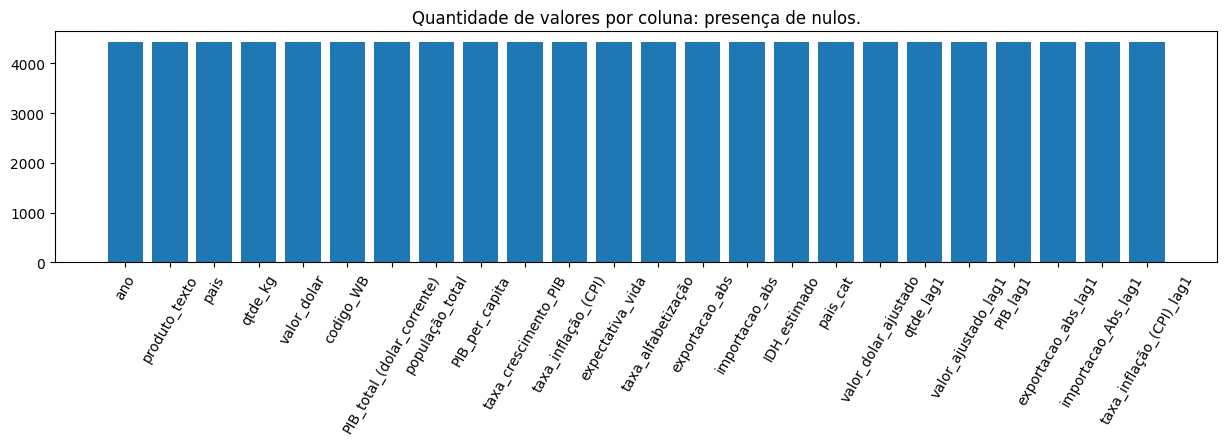

In [183]:
# verificação do dataset após tratamento para preenchimento de dados nulos.
dados_nulos = contagem_nulos(tbl_export)
gerar_grafico_valores_nulos(df = tbl_export, dados_nulos=dados_nulos)

# Tratamento de Outliers
Como possuímos colunas numéricas com diferentes escalas, torna-se necessário padronizar esses valores para que haja uma maior consistência de um modelo de Machine Learning realizar tarefas e não tomar decisões envieasadas. Além disso, os dados possuem uma grande variabilidade que podem impactar na performance do modelo. Por isso, faz-se necessário escalar esses valores. Porém, não podemos simplesmente excluir os valores distantes, pois não temos a causa da anomalia, se um erro, ou um evento aleatório, etc. Por isso, aplicamos um scale padrão, que consegue reduzir a escala e melhorar a distribuição dos dados, aproximando da normalidade.

In [184]:
tbl_export.describe(percentiles=[0,0.35,0.5,0.75,0.95])

,ano,qtde_kg,valor_dolar,PIB_total_(dolar_corrente),população_total,PIB_per_capita,taxa_crescimento_PIB,taxa_inflação_(CPI),expectativa_vida,taxa_alfabetização,exportacao_abs,importacao_abs,IDH_estimado,valor_dolar_ajustado,qtde_lag1,valor_ajustado_lag1,PIB_lag1,exportacao_abs_lag1,importacao_Abs_lag1,taxa_inflação_(CPI)_lag1
count,4422.000000,4.422000e+03,4.422000e+03,4.422000e+03,4.422000e+03,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4.422000e+03,4.422000e+03,4422.000000,4.422000e+03,4.422000e+03,4.422000e+03,4.422000e+03,4.422000e+03,4.422000e+03,4422.000000
mean,2006.681366,3.869671e+05,7.125725e+05,1.034825e+12,5.609255e+07,20725.953102,2.474699,17.046003,65.870070,81.171970,2.284494e+13,2.320478e+13,0.354761,1.051749e+06,3.646811e+05,9.960946e+05,1.013207e+12,2.223980e+13,2.261797e+13,16.741902
std,14.284092,2.215284e+06,4.453301e+06,2.992489e+12,1.833140e+08,23962.077484,4.949633,269.051817,24.571117,30.428883,4.467353e+13,4.878115e+13,0.383677,6.156060e+06,2.137903e+06,5.972468e+06,2.955153e+12,4.412798e+13,4.823785e+13,269.015532
min,1970.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,-46.433035,-4.447547,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.071873e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.447547
0%,1970.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,-46.433035,-4.447547,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.071873e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.447547
35%,2004.000000,1.212000e+03,2.916650e+03,3.070918e+10,5.149463e+06,4775.899536,1.138362,1.478286,71.773000,94.000000,1.068487e+12,1.087080e+12,0.000000,5.104539e+03,8.400000e+02,3.522077e+03,2.355206e+10,8.201251e+11,8.376561e+11,1.230395
50%,2010.000000,4.822000e+03,1.104700e+04,1.328171e+11,9.346701e+06,10946.720913,2.457622,2.487874,75.214634,95.000000,4.897467e+12,4.514540e+12,0.000000,1.933422e+04,3.660500e+03,1.483147e+04,1.189180e+11,4.420812e+12,3.958742e+12,2.341070
75%,2019.000000,4.142850e+04,7.826850e+04,5.200371e+11,3.698156e+07,33938.945312,4.580458,6.115056,79.448780,95.000000,2.711528e+13,2.438519e+13,0.769831,1.281205e+05,3.816975e+04,1.220666e+05,5.127773e+11,2.549041e+13,2.337885e+13,5.821158
95%,2023.000000,1.175538e+06,1.858499e+06,4.896994e+12,2.316640e+08,66081.719924,8.928765,24.637840,82.897439,99.000000,8.954282e+13,9.132091e+13,0.911582,3.202598e+06,1.020857e+06,3.006004e+06,4.896800e+12,8.801639e+13,9.085919e+13,23.551467
max,2023.000000,4.060457e+07,8.097690e+07,2.772071e+13,1.438070e+09,133711.794436,63.334587,11749.639632,85.532683,100.000000,3.717888e+14,3.976314e+14,0.986462,1.225105e+08,4.060457e+07,1.225105e+08,2.772071e+13,3.717888e+14,3.976314e+14,11749.639632


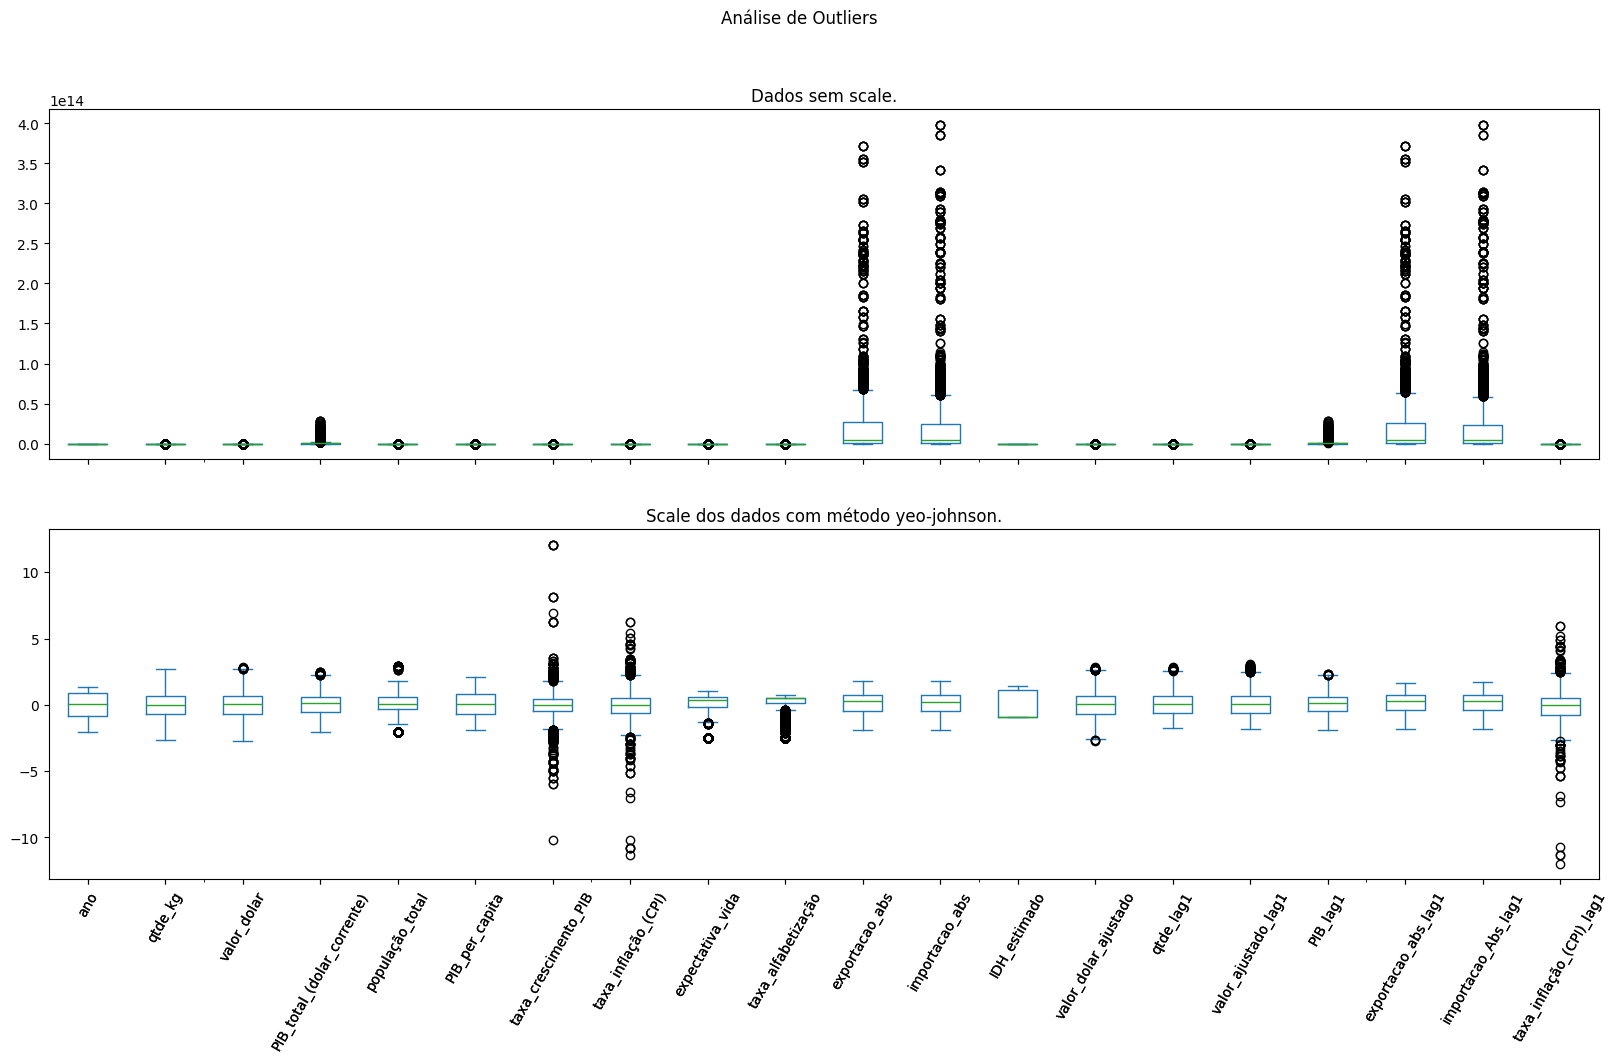

In [185]:
graficos_analise_outliers(df=tbl_export, scale=True, metodo_scale='yeo-johnson')

# Distribuição e Testes de Normalidade
Avaliando os dados, percebemos uma ausência de normalidade, seja pela amplitude de escala, ou ausência de valores. Mesmo aplicando o scale dos dados, não houve uma aproximação a distribuição normal. Essa suposição é confirmada pela análise de distribuição, gráfico quantil para para comparar as formas das distribuições, (onde o afastamento da reta indica ausência de normalidade), e teste de normalidade shapiro-wilk para o volume de dado atual. Apesar da ausência de normalidade, não há uma garantia de impacto nas métricas de avaliação do modelo de regressão e na qualidade da previsão será afetada.


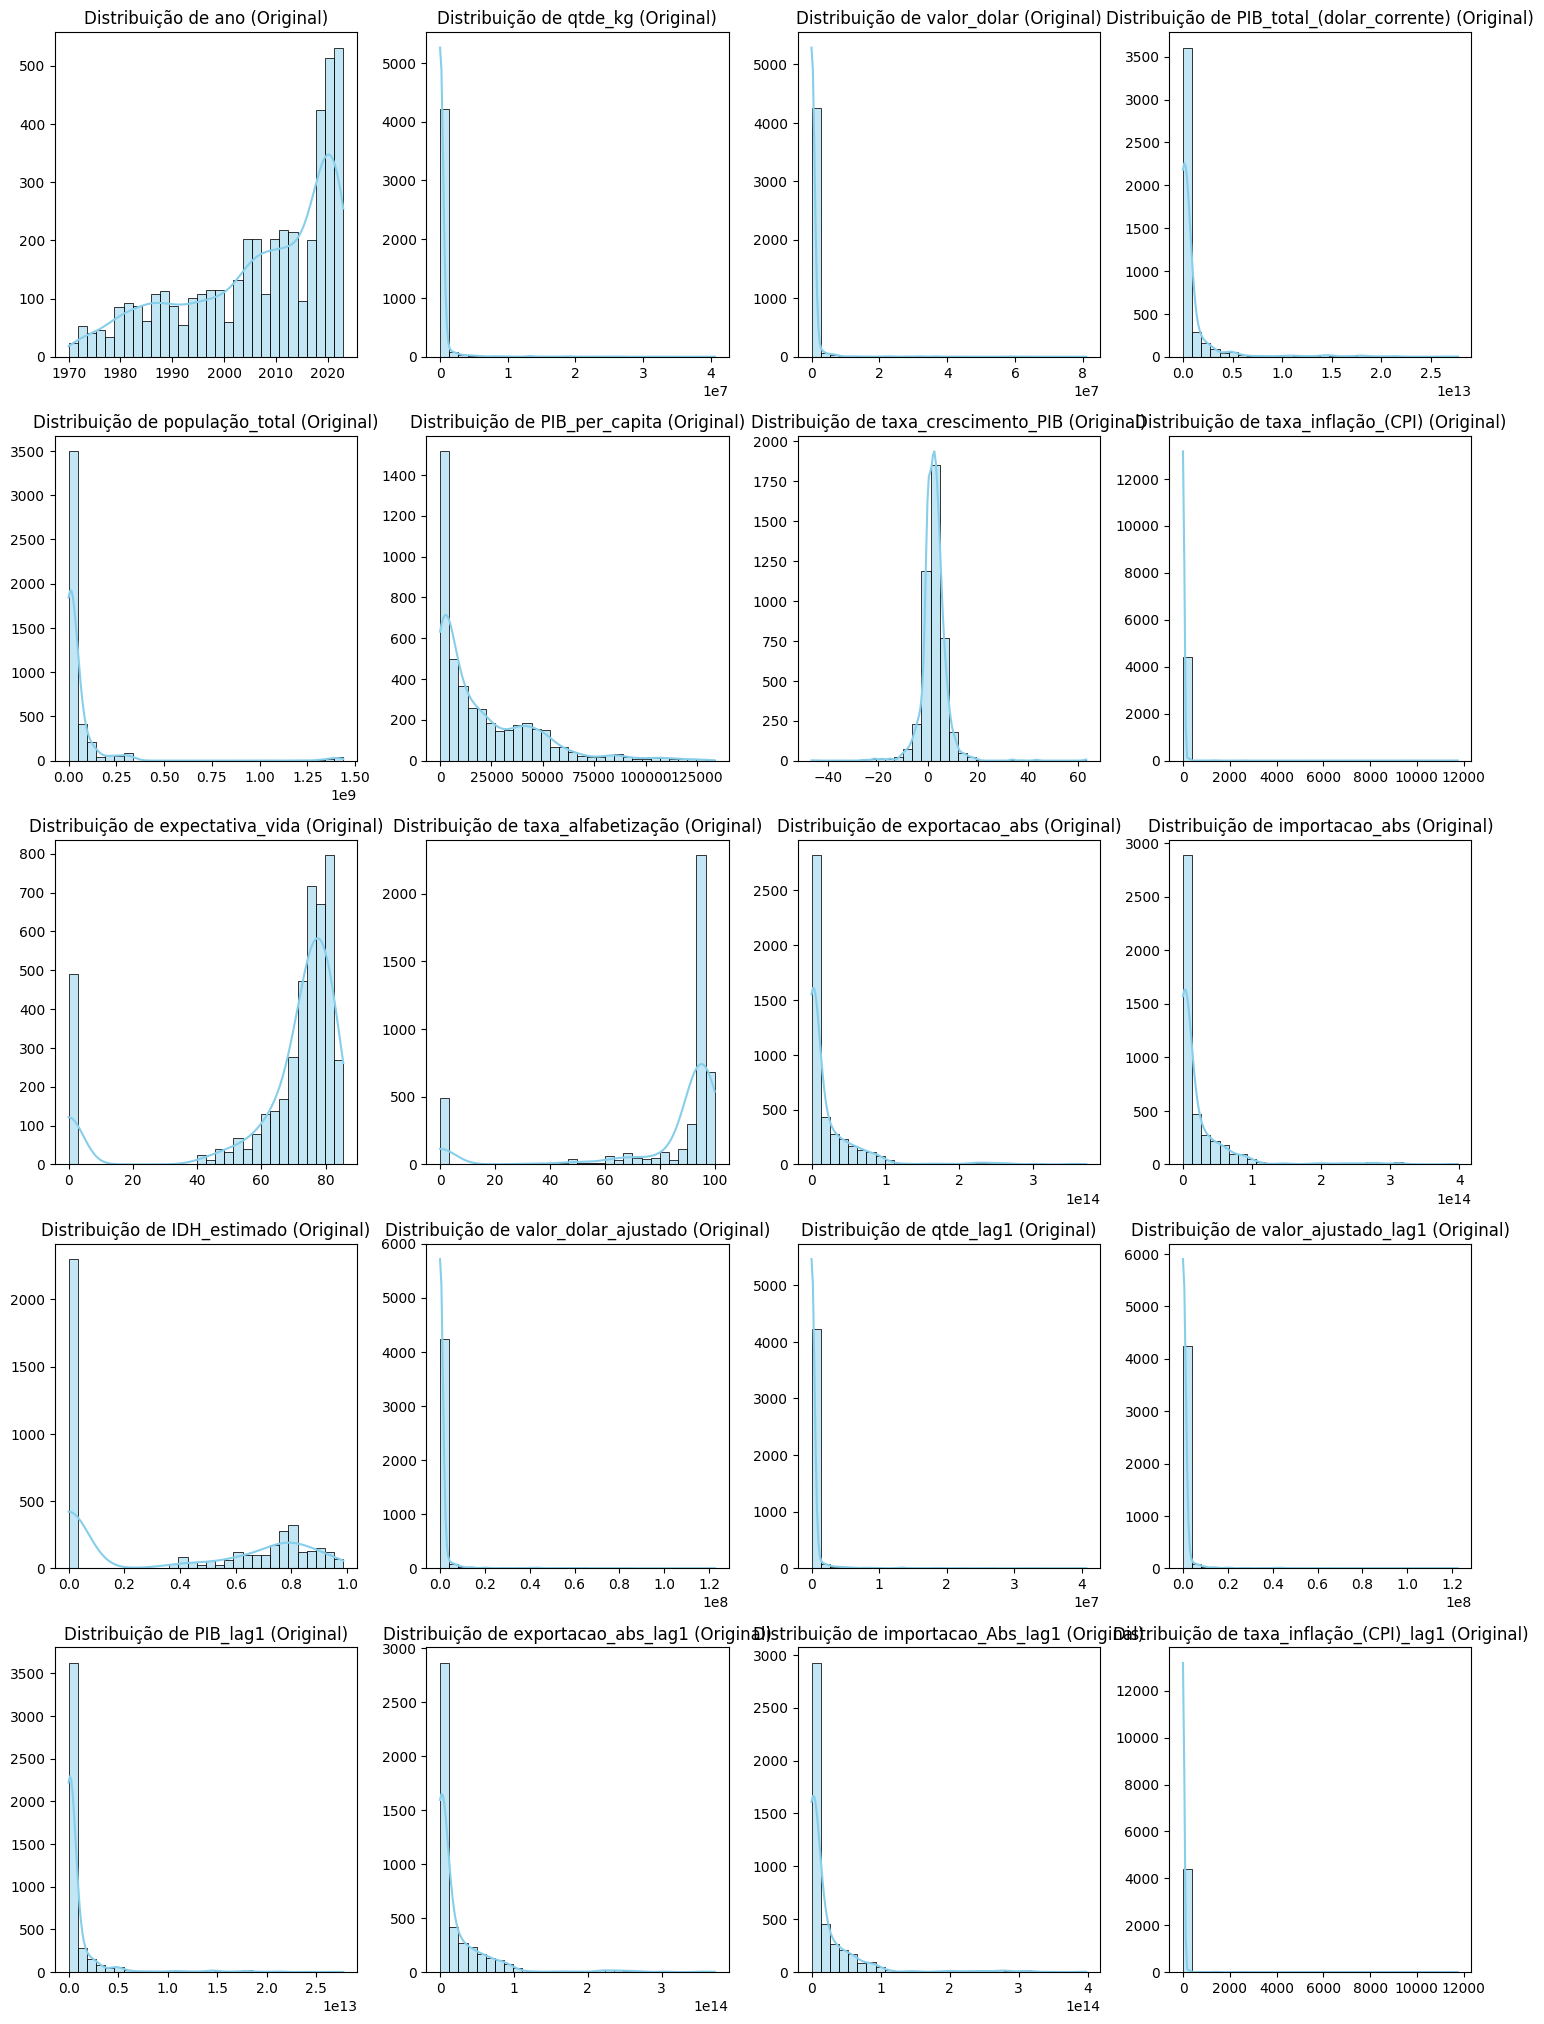

In [186]:
# análise de distribuição sem scale dos dados.
graficos_ditribuicao(tbl_export)

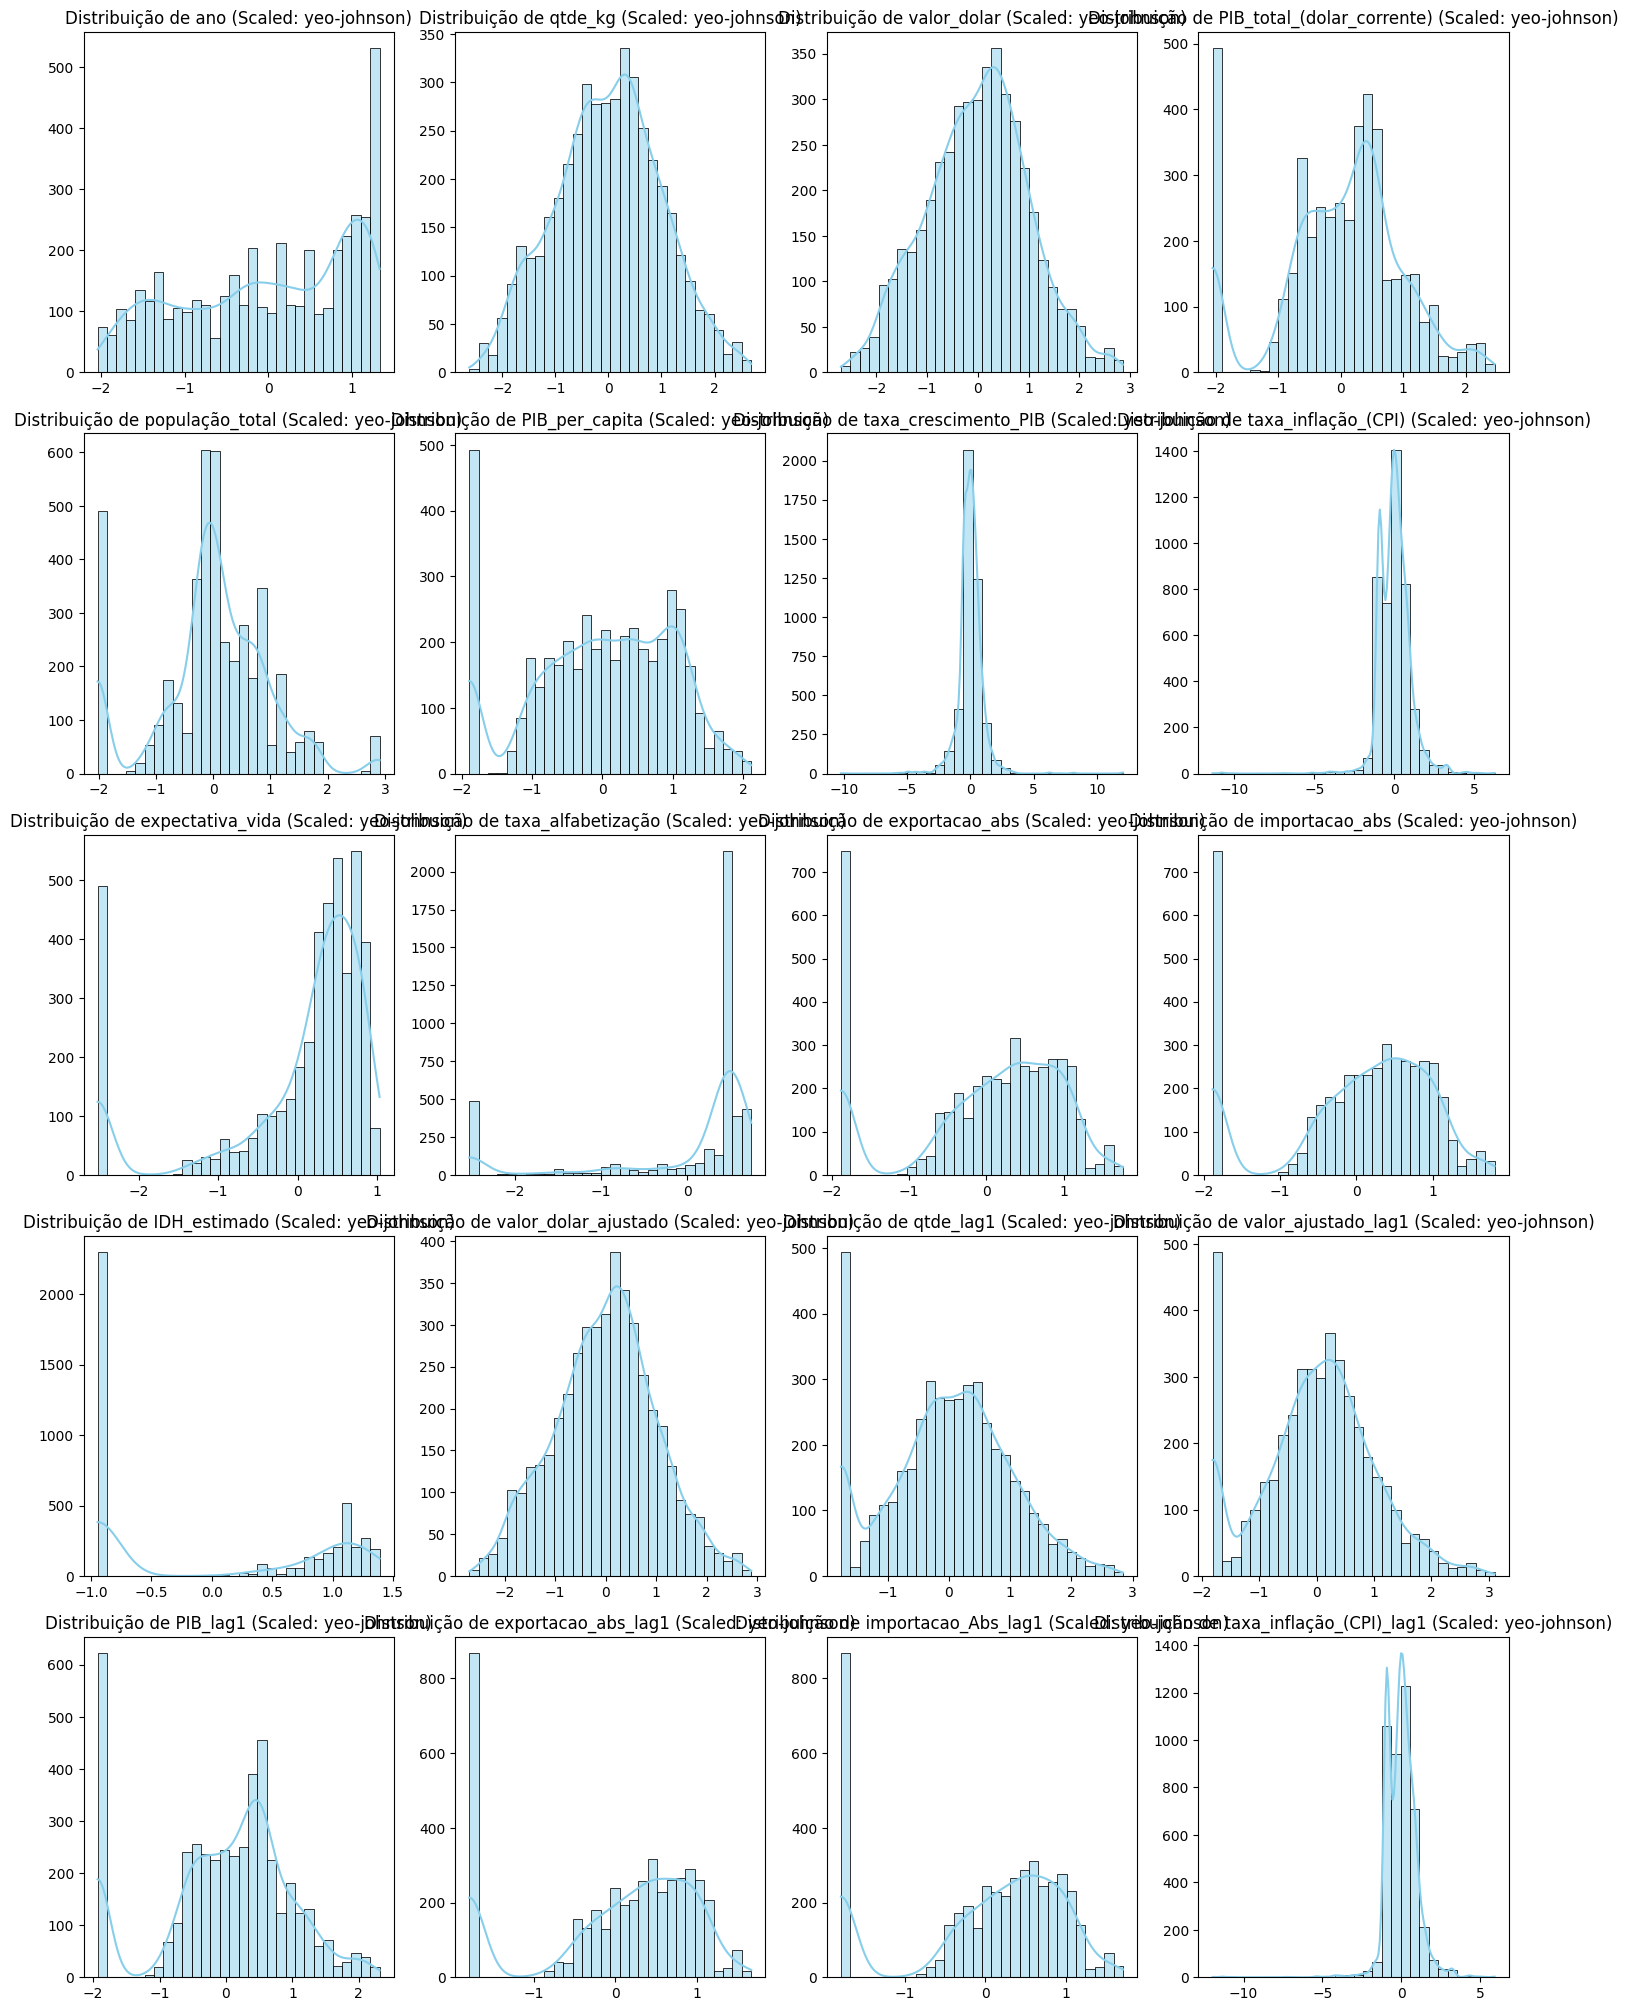

In [187]:
# análise de distribuição com scale dos dados.
graficos_ditribuicao(tbl_export, scale=True, metodo_scale='yeo-johnson')

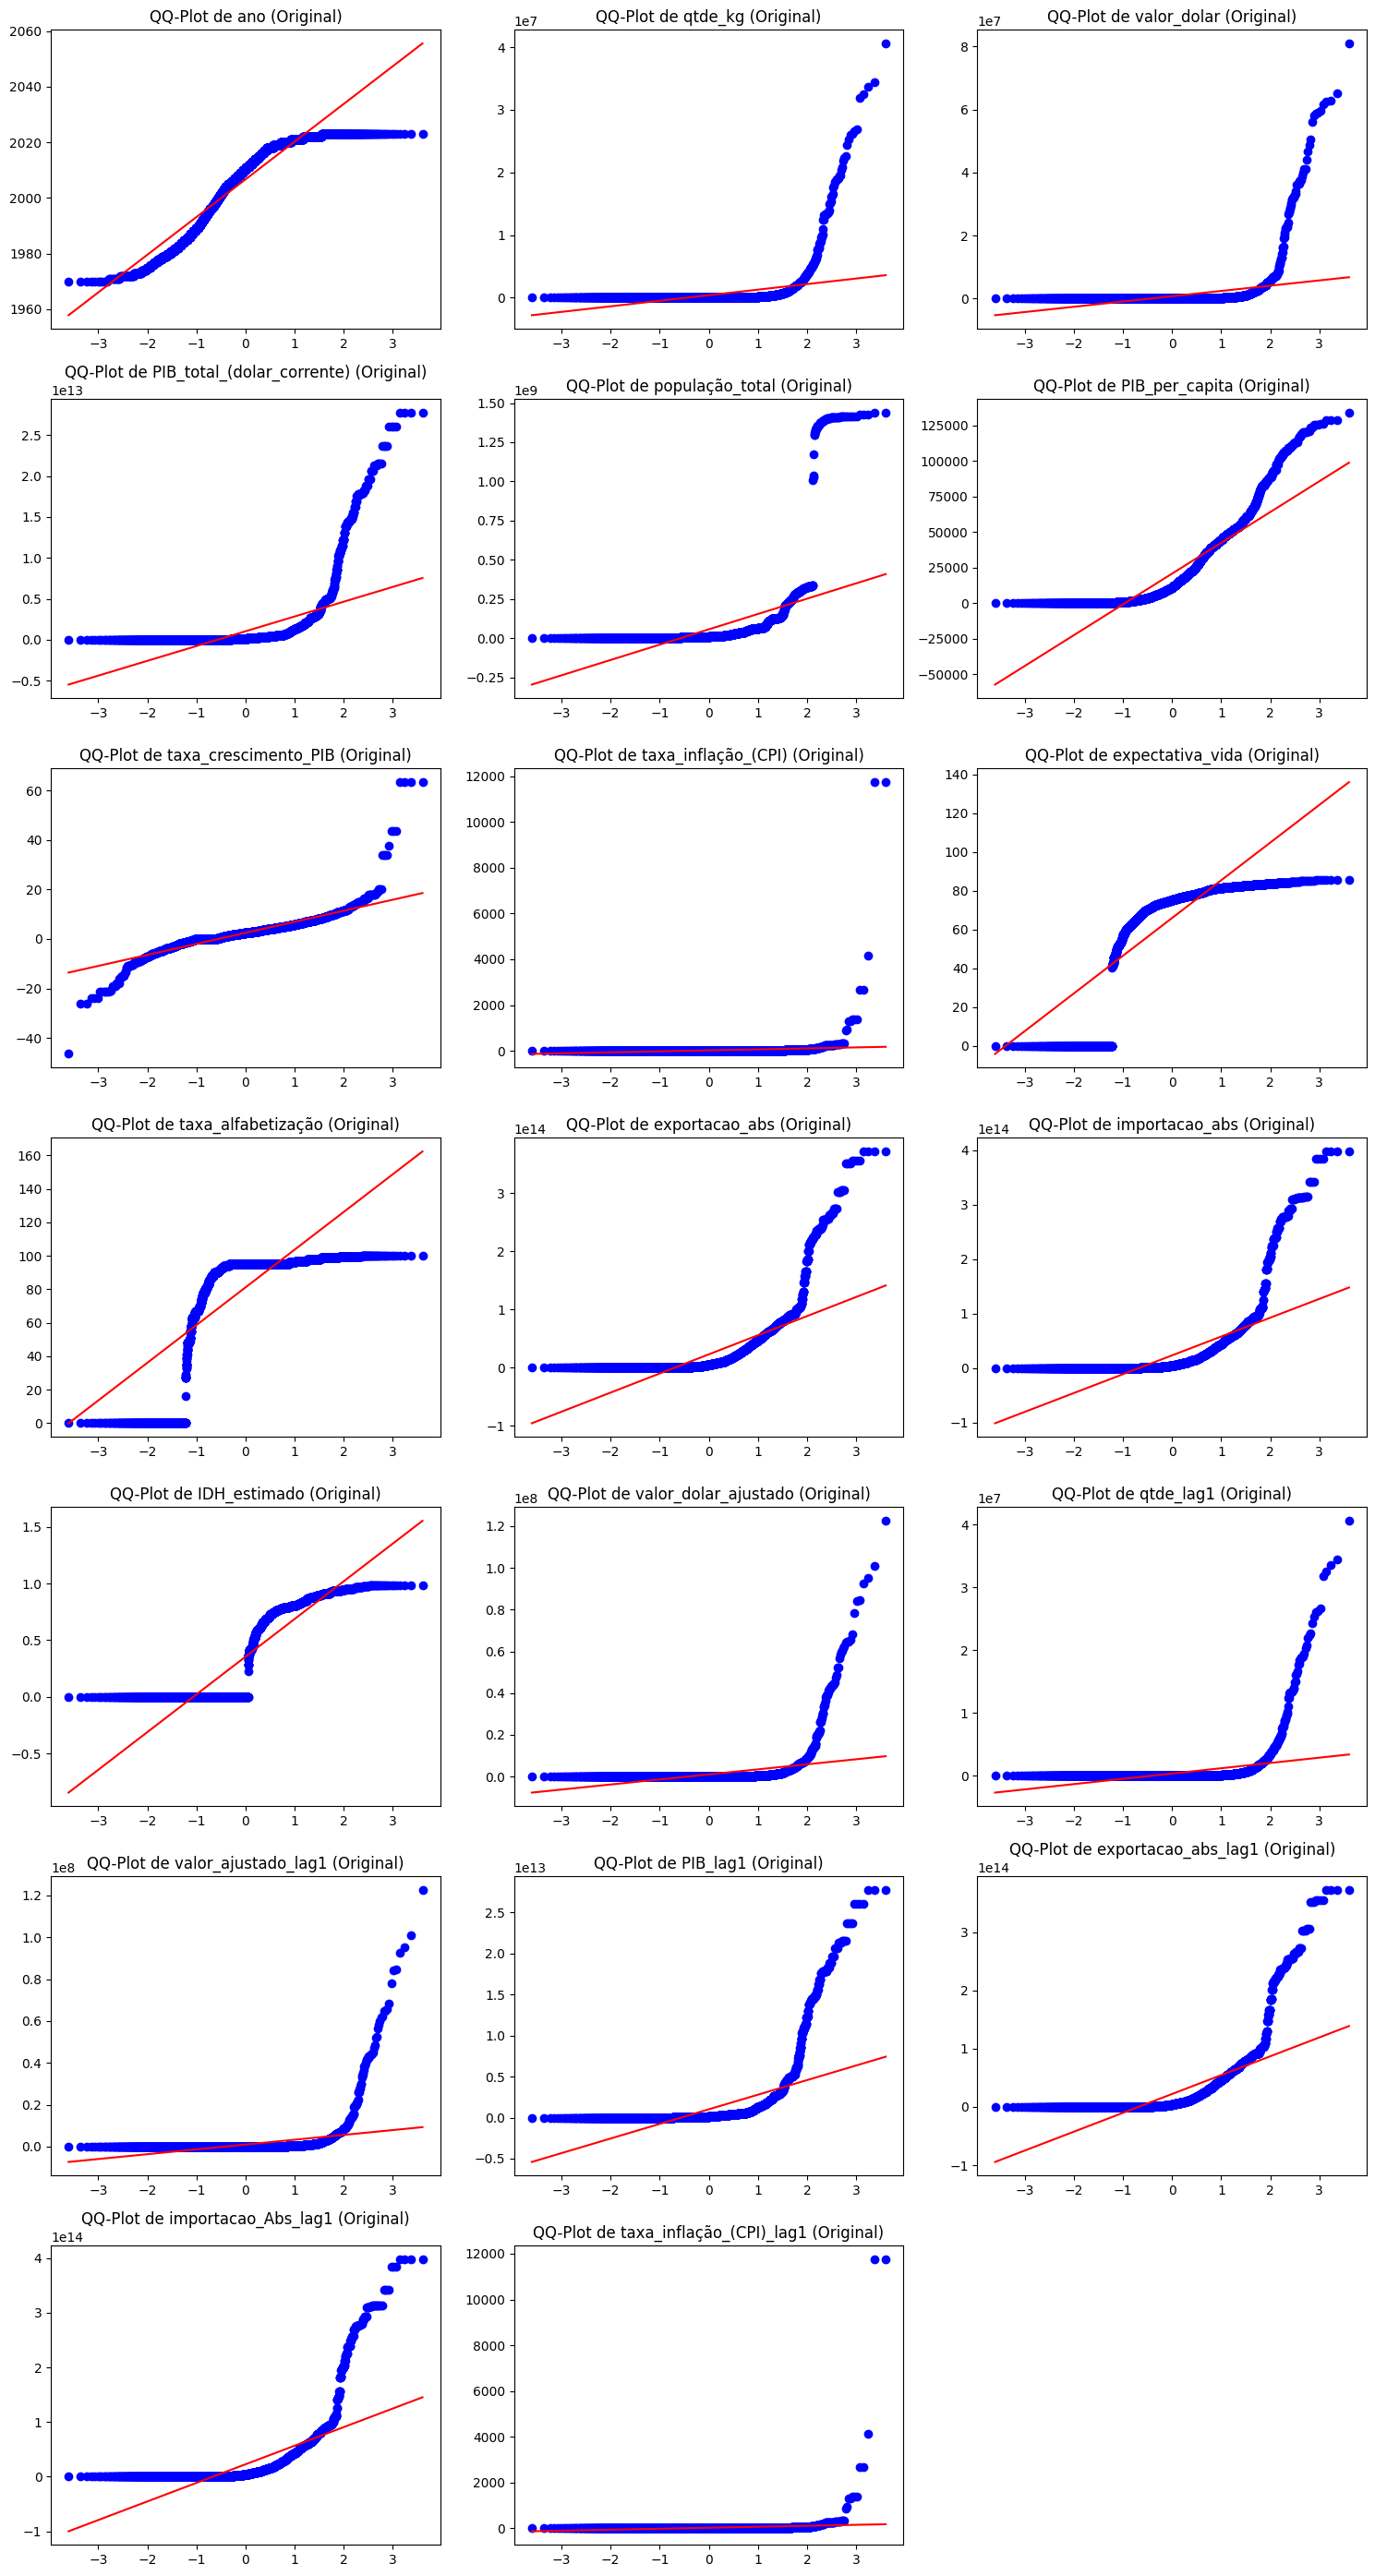

In [188]:
# análise de distribuição qq-plot sem scale dos dados.
graficos_qq_plots(tbl_export)

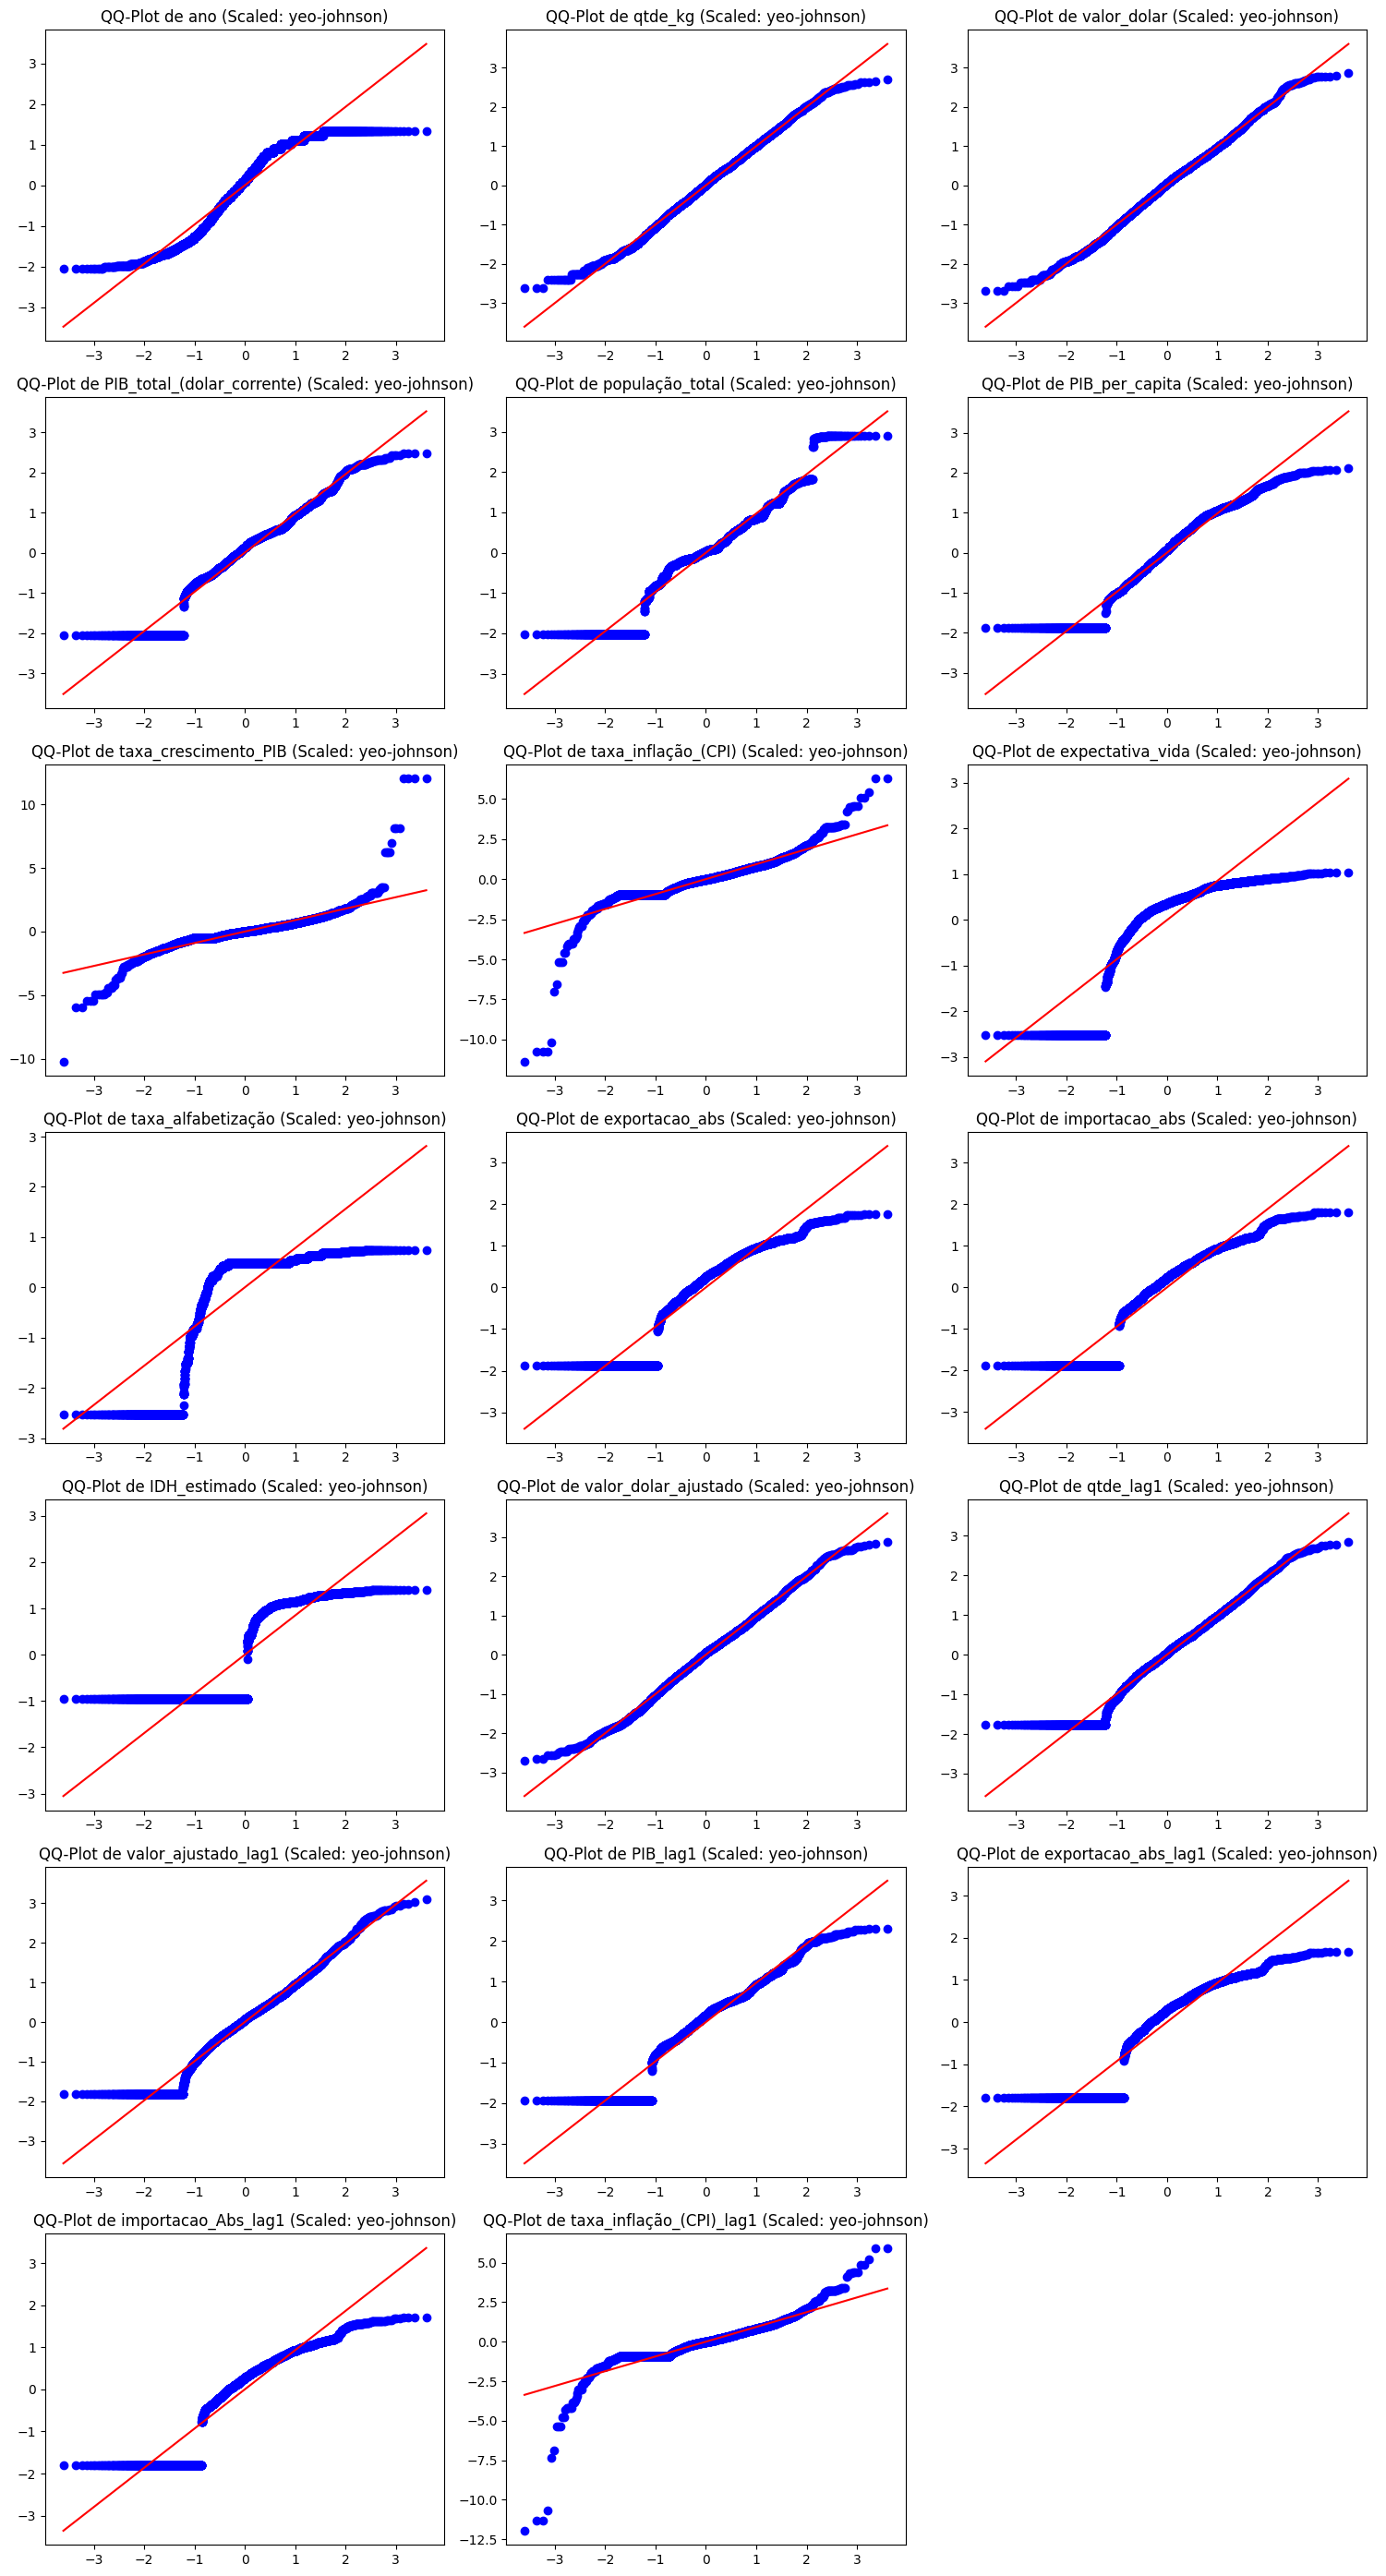

In [189]:
# análise de distribuição qq-plot com scale dos dados.
graficos_qq_plots(tbl_export, scale=True, metodo_scale='yeo-johnson')

In [190]:
# teste de normalidade com shapiro-wilk sem scale dos dados.
teste_shapiro_wilk_norm(tbl_export)

,coluna,statistic,p_value,normal
0,ano,0.900144,5.191609e-47,False
1,qtde_kg,0.161163,1.520011e-88,False
2,valor_dolar,0.141965,4.658942e-89,False
3,PIB_total_(dolar_corrente),0.364413,2.270133e-82,False
4,população_total,0.284635,5.659045e-85,False
5,PIB_per_capita,0.813331,7.874493e-58,False
6,taxa_crescimento_PIB,0.811973,5.808662e-58,False
7,taxa_inflação_(CPI),0.026642,6.003201e-92,False
8,expectativa_vida,0.624846,2.883716e-71,False
9,taxa_alfabetização,0.547406,3.998032e-75,False


In [191]:
# teste de normalidade com shapiro-wilk com scale dos dados.
teste_shapiro_wilk_norm(tbl_export, scale=True, metodo_scale='yeo-johnson')

,coluna,statistic,p_value,normal
0,ano,0.927621,6.765905e-42,False
1,qtde_kg,0.995877,8.660779e-10,False
2,valor_dolar,0.996725,2.982680e-08,False
3,PIB_total_(dolar_corrente),0.952534,1.183874e-35,False
4,população_total,0.944628,7.155393e-38,False
5,PIB_per_capita,0.960067,3.012278e-33,False
6,taxa_crescimento_PIB,0.814057,9.272146e-58,False
7,taxa_inflação_(CPI),0.866851,7.634811e-52,False
8,expectativa_vida,0.734558,1.991803e-64,False
9,taxa_alfabetização,0.608368,3.849389e-72,False


# Considerações sobre dataset de Regressão
Para esse dataset removemos as colunas `ano`(substituído pelo lag de dados das colunas numéricas), `valor_dolar`(substituído pela coluna valor_dolar_ajustado, que tras o valor histórico a valor presente), `codigo_WB`(que representa o código dos países e não tem algum uso prático) e `pais`(substituído pelo encoding de categoria dos países).
O dataset processado possui os valores escalonados e com encoding de valores categóricos de produtos e categoria de países.




In [192]:
# salva os dados no mongoDB para recuperação via api
data_dict = tbl_export.to_dict("records")
api_collection.insert_many(data_dict)

InsertManyResult([ObjectId('683f25f61f4398ff5628c403'), ObjectId('683f25f61f4398ff5628c404'), ObjectId('683f25f61f4398ff5628c405'), ObjectId('683f25f61f4398ff5628c406'), ObjectId('683f25f61f4398ff5628c407'), ObjectId('683f25f61f4398ff5628c408'), ObjectId('683f25f61f4398ff5628c409'), ObjectId('683f25f61f4398ff5628c40a'), ObjectId('683f25f61f4398ff5628c40b'), ObjectId('683f25f61f4398ff5628c40c'), ObjectId('683f25f61f4398ff5628c40d'), ObjectId('683f25f61f4398ff5628c40e'), ObjectId('683f25f61f4398ff5628c40f'), ObjectId('683f25f61f4398ff5628c410'), ObjectId('683f25f61f4398ff5628c411'), ObjectId('683f25f61f4398ff5628c412'), ObjectId('683f25f61f4398ff5628c413'), ObjectId('683f25f61f4398ff5628c414'), ObjectId('683f25f61f4398ff5628c415'), ObjectId('683f25f61f4398ff5628c416'), ObjectId('683f25f61f4398ff5628c417'), ObjectId('683f25f61f4398ff5628c418'), ObjectId('683f25f61f4398ff5628c419'), ObjectId('683f25f61f4398ff5628c41a'), ObjectId('683f25f61f4398ff5628c41b'), ObjectId('683f25f61f4398ff5628c4

In [193]:
# exclusão de colunas do dataset para o modelo de regressao
tbl_export_regressor = tbl_export.drop(columns=['ano','valor_dolar','codigo_WB','pais'])
tbl_export_regressor

,produto_texto,qtde_kg,PIB_total_(dolar_corrente),população_total,PIB_per_capita,taxa_crescimento_PIB,taxa_inflação_(CPI),expectativa_vida,taxa_alfabetização,exportacao_abs,importacao_abs,IDH_estimado,pais_cat,valor_dolar_ajustado,qtde_lag1,valor_ajustado_lag1,PIB_lag1,exportacao_abs_lag1,importacao_Abs_lag1,taxa_inflação_(CPI)_lag1
23212,Espumantes,49,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000,0.0,0.000000e+00,0.000000e+00,0.000000,cat_C,378.107277,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
23849,Espumantes,199,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000,0.0,0.000000e+00,0.000000e+00,0.000000,cat_C,1664.196834,49.0,378.107277,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25123,Espumantes,2250,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000,0.0,0.000000e+00,0.000000e+00,0.000000,cat_C,16487.399209,199.0,1664.196834,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25760,Espumantes,2896,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000,0.0,0.000000e+00,0.000000e+00,0.000000,cat_C,16463.004531,2250.0,16487.399209,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
26397,Espumantes,5948,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000,0.0,0.000000e+00,0.000000e+00,0.000000,cat_C,25658.351424,2896.0,16463.004531,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33434,Espumantes,16,4.103240e+11,99680655.0,4116.385761,8.123514,3.156507,74.502,96.0,3.849317e+13,3.692010e+13,0.767459,cat_C,20.365587,144.0,432.961900,3.664748e+11,3.439373e+13,3.401825e+13,1.834716
33601,Uvas frescas,60,4.103240e+11,99680655.0,4116.385761,8.123514,3.156507,74.502,96.0,3.849317e+13,3.692010e+13,0.767459,cat_C,278.686986,100.0,313.723730,4.103240e+11,3.849317e+13,3.692010e+13,3.156507
33297,Vinhos de mesa,130,4.103240e+11,99680655.0,4116.385761,8.123514,3.156507,74.502,96.0,3.849317e+13,3.692010e+13,0.767459,cat_C,296.908828,86.0,707.830718,4.103240e+11,3.849317e+13,3.692010e+13,3.156507
34238,Uvas frescas,63,4.297170e+11,100352192.0,4282.088517,5.046431,3.252893,74.588,96.0,3.746132e+13,3.401075e+13,0.767459,cat_C,182.220507,60.0,278.686986,4.103240e+11,3.849317e+13,3.692010e+13,3.156507


# Alta correlação entre as variáveis: alta multicolinearidade
Percebemos uma alta correlação entre colunas de indicadores econômicos, especialmente entre indicadores dependentes, como usadas no cálculo do `IDH_estimado`: `expectativa_vida`, `taxa_alfabetizacao` e `populacao_total`.
O target `qtde_kg` está diretamente correlacionado as features correspondentes a grande volume e a influência temporal (lag): `qtde_kg_lag1`, `valor_dolar_ajustado`, `valor_ajustado_lag1`. 
Ainda a uma correlação quase alta a categoria pais_cat_A, comprovando que países com maior volume de compras tem forte relação com a quantidade exportada.
Essa análise é confirmada pela análise VIF, que indica valores acima de 10 para variáveis numéricas, exigindo que façamos algum processo de seleção de features para redução desse impacto.

In [194]:
# encoding das variáveis categóricas
encoder = OneHotEncoder( sparse_output=False)
tbl_cat = pd.DataFrame(
encoder.fit_transform(tbl_export_regressor.select_dtypes(include='object')),
columns=encoder.get_feature_names_out()
)

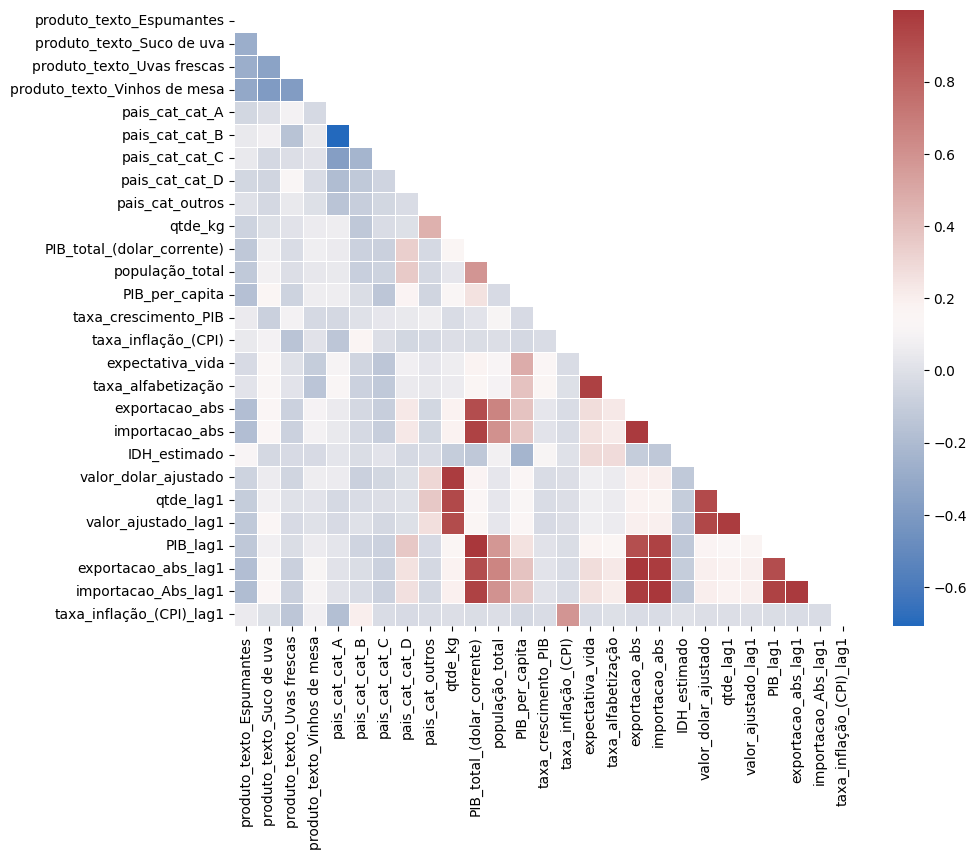

In [ ]:
# analisar ausência da multicolinearidade
df_corr = pd.concat([tbl_cat, tbl_export_regressor.select_dtypes(include='number')],axis=1).corr()
plt.figure(figsize=(10,8))
mask = np.triu(df_corr)
sns.heatmap(df_corr,linewidths=0.5, cmap='vlag', mask = mask)
plt.show()

In [196]:
# análise 
tbl_vif_data = vif_analise(tbl_export_regressor.select_dtypes(include='number'))
tbl_vif_data

,Feature,VIF
0,qtde_kg,32.553353
1,PIB_total_(dolar_corrente),1304.739008
2,população_total,2.710952
3,PIB_per_capita,2.186660
4,taxa_crescimento_PIB,1.060192
5,taxa_inflação_(CPI),1.520788
6,expectativa_vida,13.703849
7,taxa_alfabetização,11.957158
8,exportacao_abs,1062.870101
9,importacao_abs,1096.831787


In [197]:
# salvar o dataset para o modelo de regressao
tbl_export_regressor.to_csv('../data/processed/dataset_exportacao_regressor_processed.csv', index=False)

# Agrupamento de Dados para modelo de Clustering
Para esse modelo, decidimos agrupar os dados por países e remover a influência temporal dos dados, pois queremos entender o comportamento entre uma categoria alvo `pais` e as demais features.

In [198]:
# exclusão de colunas do dataset para o modelo de clustering.
tbl_export_clustering = tbl_export.drop(columns=['valor_dolar', 'codigo_WB'])

In [200]:
# agupamento dos dados para construção do dataset para o modelo de clustering.
colunas_media = [
    'PIB_total_(dolar_corrente)', 'população_total', 'PIB_per_capita',
    'taxa_crescimento_PIB', 'taxa_inflação_(CPI)',
    'expectativa_vida', 'taxa_alfabetização',
    'exportacao_abs', 'importacao_abs', 'IDH_estimado'
]

# Criando o dicionário automaticamente
agg_dict = {col: 'mean' for col in colunas_media}

# Outras agregações específicas
agg_dict.update({
    'qtde_kg': 'sum',
    'valor_dolar_ajustado': 'sum',
     'produto_texto': pd.Series.nunique,
    'ano': pd.Series.nunique
})


tbl_export_clustering = tbl_export_clustering.groupby(['pais']).agg(agg_dict)


In [202]:
# renome das colunas para identificação dos dados numéricos

nome_colunas = {'PIB_total_(dolar_corrente)':'media_PIB_total_(dolar_corrente)', 
 'população_total':'media_população_total', 'PIB_per_capita':'media_PIB_per_capita',
       'taxa_crescimento_PIB':'media_taxa_crescimento_PIB', 'taxa_inflação_(CPI)':'media_taxa_inflação_(CPI)', 
       'expectativa_vida':'media_expectativa_vida', 'taxa_alfabetização':'media_taxa_alfabetização',
         'exportacao_abs':'media_exportacao_abs', 'importacao_abs':'media_importacao_abs',
       'IDH_estimado':'media_IDH_estimado', 'qtde_kg':'soma_qtde_kg', 
       'valor_dolar_ajustado':'soma_valor_dolar_ajustado', 
       'produto_texto':'vl_distinto_produto_texto',
       'ano':'vl_distinto_ano'}

tbl_export_clustering.rename(columns = nome_colunas, inplace=True)
tbl_export_clustering

,media_PIB_total_(dolar_corrente),media_população_total,media_PIB_per_capita,media_taxa_crescimento_PIB,media_taxa_inflação_(CPI),media_expectativa_vida,media_taxa_alfabetização,media_exportacao_abs,media_importacao_abs,media_IDH_estimado,soma_qtde_kg,soma_valor_dolar_ajustado,vl_distinto_produto_texto,vl_distinto_ano
pais,,,,,,,,,,,,,,
Paises Baixos,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,28229,1.971864e+05,1,14
Afeganistao,1.426000e+10,4.000041e+07,356.496214,-20.738839,5.133203,60.417000,37.000000,2.045190e+11,5.286118e+11,0.353505,11,5.325200e+01,1,1
Africa do Sul,3.416662e+11,5.738475e+07,5882.428332,-0.004407,5.738670,63.923333,90.916667,9.837625e+12,9.463701e+12,0.718727,72627,1.654070e+05,4,8
"Alemanha, Republica Democratica da",0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,45215666,1.220199e+08,4,52
Angola,4.515203e+10,2.002802e+07,1890.364561,3.664757,186.149889,51.780883,77.946033,2.150125e+12,1.504712e+12,0.297646,7109031,2.045122e+07,4,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tuvalu,5.129502e+07,1.057700e+04,4852.454550,3.644817,0.500581,66.112333,95.000000,0.000000e+00,0.000000e+00,0.000000,9,3.681664e+01,2,3
Uruguai,3.409896e+10,3.269740e+06,10260.815180,2.562814,19.898181,75.285760,97.280000,8.498052e+11,8.103374e+11,0.805750,4307927,8.131442e+06,4,41
Vanuatu,9.749754e+08,3.068514e+05,3173.674605,-1.504626,5.651967,70.642500,87.449998,1.344584e+10,4.984252e+10,0.702894,266,6.886336e+02,4,4


In [ ]:
# salvar o dataset para o modelo de clusterização
tbl_export_clustering.to_csv('../data/processed/dataset_exportacao_clustering_processed.csv')